# Benchmark `flax.linen` models with APEBench

This tutorial notebook will be conceptually similar to [the one using the newer
`flax.nnx` API](benchmark_flax_models_with_nnx.ipynb). For more comments, please
refer to that notebook.

In [1]:
import apebench

import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as nn
from tqdm.autonotebook import tqdm
import optax
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

/home/koehler/miniconda3/envs/apebench_dev/lib/python3.12/site-packages/trainax/_general_trainer.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## 1. Create Data with APEBench

As an example, we will use an advection scenario in difficulty mode with mostly
default settings.

In [2]:
advection_scenario = apebench.scenarios.difficulty.Advection(
    # A simple optimization setup that will be mimicked by Flax
    optim_config="adam;10_000;constant;1e-4",
    # The default metric for APEBench scenarios is always `"mean_nRMSE"`. Let's
    # add some more metrics to the report. One based on the spectrum up until
    # (including) the fifth mode and a Sobolev-based metric that also considers
    # the first derivative.
    report_metrics="mean_nRMSE,mean_fourier_nRMSE;0;5;0,mean_H1_nRMSE",
)

Create train **trajectories** and test **initial conditions** with APEBench.

In [3]:
train_data = advection_scenario.get_train_data()
test_ic_set = advection_scenario.get_test_ic_set()
train_data.shape, test_ic_set.shape

((50, 51, 1, 160), (30, 1, 160))

## 2. Train `flax.linen` model

### Rearrange data
We have to rearrange our data to have the channels last convention

In [4]:
train_data = np.moveaxis(train_data, -2, -1)
test_ic_set = np.moveaxis(test_ic_set, -2, -1)
train_data.shape, test_ic_set.shape

((50, 51, 160, 1), (30, 160, 1))

### Data preprocessing

From here on, you are free to do with the `train_data` what you what. The
simplest approach would be **one-step supervised learning**. For this, we slice
windows of length two across both the trajectory and the time axis.

In [5]:
substacked_data = jax.vmap(apebench.exponax.stack_sub_trajectories, in_axes=(0, None))(
    train_data, 2
)
substacked_data.shape

(50, 50, 2, 160, 1)

Then, we can merge sample and window axis into a joint batch axis.

In [6]:
train_windows = jnp.concatenate(substacked_data)
train_windows.shape

(2500, 2, 160, 1)

### Model Definition

Just a simple ReLU feedforward ConvNet.

In [7]:
class CNN(nn.Module):
    depth: int
    width: int

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=self.width, kernel_size=(3,), padding="CIRCULAR")(x)
        x = nn.relu(x)
        for _ in range(self.depth - 1):
            x = nn.Conv(features=self.width, kernel_size=(3,), padding="CIRCULAR")(x)
            x = nn.relu(x)
        x = nn.Conv(features=1, kernel_size=(3,), padding="CIRCULAR")(x)
        return x

### Training Loop

Access the attributes of the APEBench scenario to use the same hyperparameters.

In [8]:
cnn = CNN(width=34, depth=10)
params = cnn.init(jax.random.PRNGKey(0), train_windows[:, 0])
optimizer = optax.adam(1e-4)
opt_state = optimizer.init(params)


def one_step_supervised_loss(params, batch):
    inputs, targets = batch[:, 0], batch[:, 1]
    predictions = cnn.apply(params, inputs)
    return jnp.mean((predictions - targets) ** 2)


@jax.jit
def train_step(params, state, batch):
    loss, grad = jax.value_and_grad(one_step_supervised_loss)(params, batch)
    updates, new_opt_state = optimizer.update(grad, state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, loss


loss_history = []
for batch in tqdm(
    apebench.pdequinox.cycling_dataloader(
        train_windows,
        batch_size=20,
        num_steps=10_000,
        key=jax.random.PRNGKey(42),
    )
):
    params, opt_state, loss = train_step(params, opt_state, batch)
    loss_history.append(loss)

10000it [00:13, 750.95it/s]


Let's visualize the loss history. It's a bit noisy towards the end, but let's
stick with a constant learning rate for simplicity.

Text(0, 0.5, 'Train Loss')

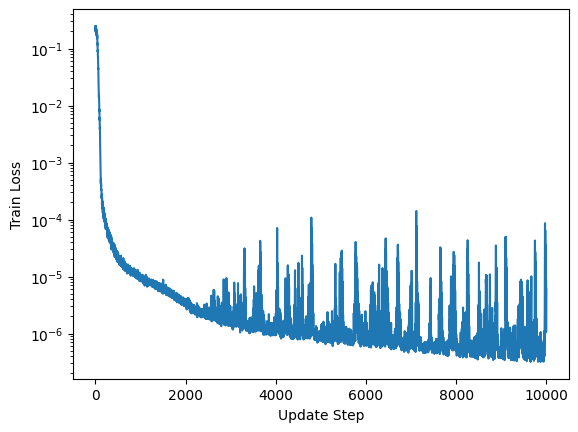

In [9]:
plt.semilogy(loss_history)
plt.xlabel("Update Step")
plt.ylabel("Train Loss")

## 3. Rollout the model

Rolling out the model requires calling it autoregressively, i.e., feeding it
based on its own output. This can be done by appending to a list and then
calling `jnp.stack`. However, it is more efficient to use `jax.lax.scan` which
is wrapped by `exponax.rollout`.

⚠️ The neural rollout must be **without** the initial conditions.

In [10]:
neural_rollout = apebench.exponax.rollout(
    lambda u: cnn.apply(params, u),
    advection_scenario.test_temporal_horizon,  # 200
)(test_ic_set)
neural_rollout.shape

(200, 30, 160, 1)

## 4. Perform tests on the rollout

### Rearrange data

Requires to change channel and spatial axes. APEBench also follows the
convention that the zeroth axis is the batch axis, and the next axis is for the
temporal snapshots. This must also be adjusted.

In [11]:
# Change to format (batch, time, channels, spatial)
neural_rollout = np.moveaxis(neural_rollout, 0, 1)
neural_rollout = np.moveaxis(neural_rollout, -1, -2)
neural_rollout.shape

(30, 200, 1, 160)

### Perform tests

Our `neural_rollout` is now of a format supported by `scenario.perform_tests_on_rollout`.

In [12]:
test_dict = advection_scenario.perform_tests_on_rollout(neural_rollout)

Now we find the same keys in the `test_dict` as set up for the `report_metrics`

In [13]:
test_dict.keys(), advection_scenario.report_metrics

(dict_keys(['mean_nRMSE', 'mean_fourier_nRMSE;0;5;0', 'mean_H1_nRMSE']),
 'mean_nRMSE,mean_fourier_nRMSE;0;5;0,mean_H1_nRMSE')

For each key, there is an array attached. It is of the shape `(num_seeds,
test_temporal_horizon)`. Since, the `neural_rollout` did not have a leading
`num_seeds` axis, this axis appears as singleton. The axis thereafter is due to
the 200 time steps performed in the test.

In [14]:
for key, value in test_dict.items():
    print(f"{key}: {value.shape}")

mean_nRMSE: (1, 200)
mean_fourier_nRMSE;0;5;0: (1, 200)
mean_H1_nRMSE: (1, 200)


### Rollout metrics

Let's visualize the error over time. Metrics with a full spectrum, even more so
the metric with derivatives (`"mean_H1_nRMSE"`) are worse, likely because
**nonlinear** networks applied to linear time stepping problems produce spurious
energy in higher modes. This is problematic since linear PDEs on periodic BCs
remain bandlimited.

However, this is not a problem of `flax.linen` but a general problem of neural
emulators for linear PDEs. Hence, let's just acknowledge that the model performs
reasonable for at least ~50 time steps which is remarkable since it was only
trained to predict one step into the future and never multiple steps
autoregressively.

(-0.1, 1.1)

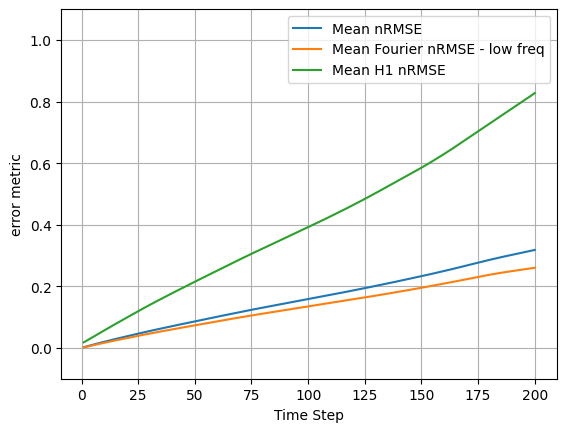

In [15]:
time_steps = jnp.arange(1, advection_scenario.test_temporal_horizon + 1)
plt.plot(
    time_steps,
    test_dict["mean_nRMSE"][0],
    label="Mean nRMSE",
)
plt.plot(
    time_steps,
    test_dict["mean_fourier_nRMSE;0;5;0"][0],
    label="Mean Fourier nRMSE - low freq",
)
plt.plot(
    time_steps,
    test_dict["mean_H1_nRMSE"][0],
    label="Mean H1 nRMSE",
)
plt.xlabel("Time Step")
plt.ylabel("error metric")
plt.legend()
plt.grid()
plt.ylim(-0.1, 1.1)

### Aggregated Metrics

Similar to the [APEBench paper](https://arxiv.org/abs/2411.00180), let us
aggregate over the first 100 time steps with a geometric mean.

In [16]:
UP_TO = 100
test_dict_gmean = {
    key: stats.gmean(value[:, :UP_TO], axis=1) for key, value in test_dict.items()
}
test_dict_gmean

{'mean_nRMSE': array([0.06692272], dtype=float32),
 'mean_fourier_nRMSE;0;5;0': array([0.05657782], dtype=float32),
 'mean_H1_nRMSE': array([0.17492542], dtype=float32)}